# MMDetection for on balloon dataset

Reproduce https://github.com/CrabBoss-lab/openmmlab-Camp/tree/master/03-mmdetection-task


## Setup

In [1]:
# !pip install -U openmim
# !mim install mmengine
# !mim install 'mmcv==2.0.0rc3'
# !mim install "mmdet>=3.0.0rc6"
# !pip install opencv-python pillow tqdm pycocotools -i https://pypi.tuna.tsinghua.edu.cn/simple
!rm -rf
!git clone -b tutorials https://github.com/open-mmlab/mmdetection.git

正克隆到 'mmdetection'...
remote: Enumerating objects: 36456, done.
remote: Counting objects: 100% (1110/1110), done.
remote: Compressing objects: 100% (656/656), done.
remote: Total 36456 (delta 580), reused 788 (delta 440), pack-reused 35346
接收对象中: 100% (36456/36456), 56.87 MiB | 14.79 MiB/s, 完成.
处理 delta 中: 100% (25518/25518), 完成.


In [2]:
import os
os.chdir('mmdetection')

In [3]:
os.getcwd()

'/home/featurize/mmdetection'

## Data downloading

In [4]:
!wget https://download.openmmlab.com/mmyolo/data/balloon_dataset.zip

--2023-06-18 11:41:28--  https://download.openmmlab.com/mmyolo/data/balloon_dataset.zip
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 38741381 (37M) [application/zip]
正在保存至: “balloon_dataset.zip”

balloon_dataset.zip 100%[===================>]  36.95M  11.8MB/s    用时 3.5s    

2023-06-18 11:41:31 (10.5 MB/s) - 已保存 “balloon_dataset.zip” [38741381/38741381])



In [5]:
!unzip balloon_dataset.zip -d balloon_dataset && rm balloon_dataset.zip 

Archive:  balloon_dataset.zip
   creating: balloon_dataset/balloon/
   creating: balloon_dataset/balloon/train/
  inflating: balloon_dataset/balloon/train/via_region_data.json  
   creating: balloon_dataset/__MACOSX/
   creating: balloon_dataset/__MACOSX/balloon/
   creating: balloon_dataset/__MACOSX/balloon/train/
  inflating: balloon_dataset/__MACOSX/balloon/train/._via_region_data.json  
  inflating: balloon_dataset/balloon/train/53500107_d24b11b3c2_b.jpg  
  inflating: balloon_dataset/__MACOSX/balloon/train/._53500107_d24b11b3c2_b.jpg  
  inflating: balloon_dataset/balloon/train/120853323_d4788431b9_b.jpg  
  inflating: balloon_dataset/__MACOSX/balloon/train/._120853323_d4788431b9_b.jpg  
  inflating: balloon_dataset/balloon/train/126700562_8e27720147_b.jpg  
  inflating: balloon_dataset/__MACOSX/balloon/train/._126700562_8e27720147_b.jpg  
  inflating: balloon_dataset/balloon/train/145053828_e0e748717c_b.jpg  
  inflating: balloon_dataset/__MACOSX/balloon/train/._145053828_e0e7487

## Visualize some images to verify the dataset

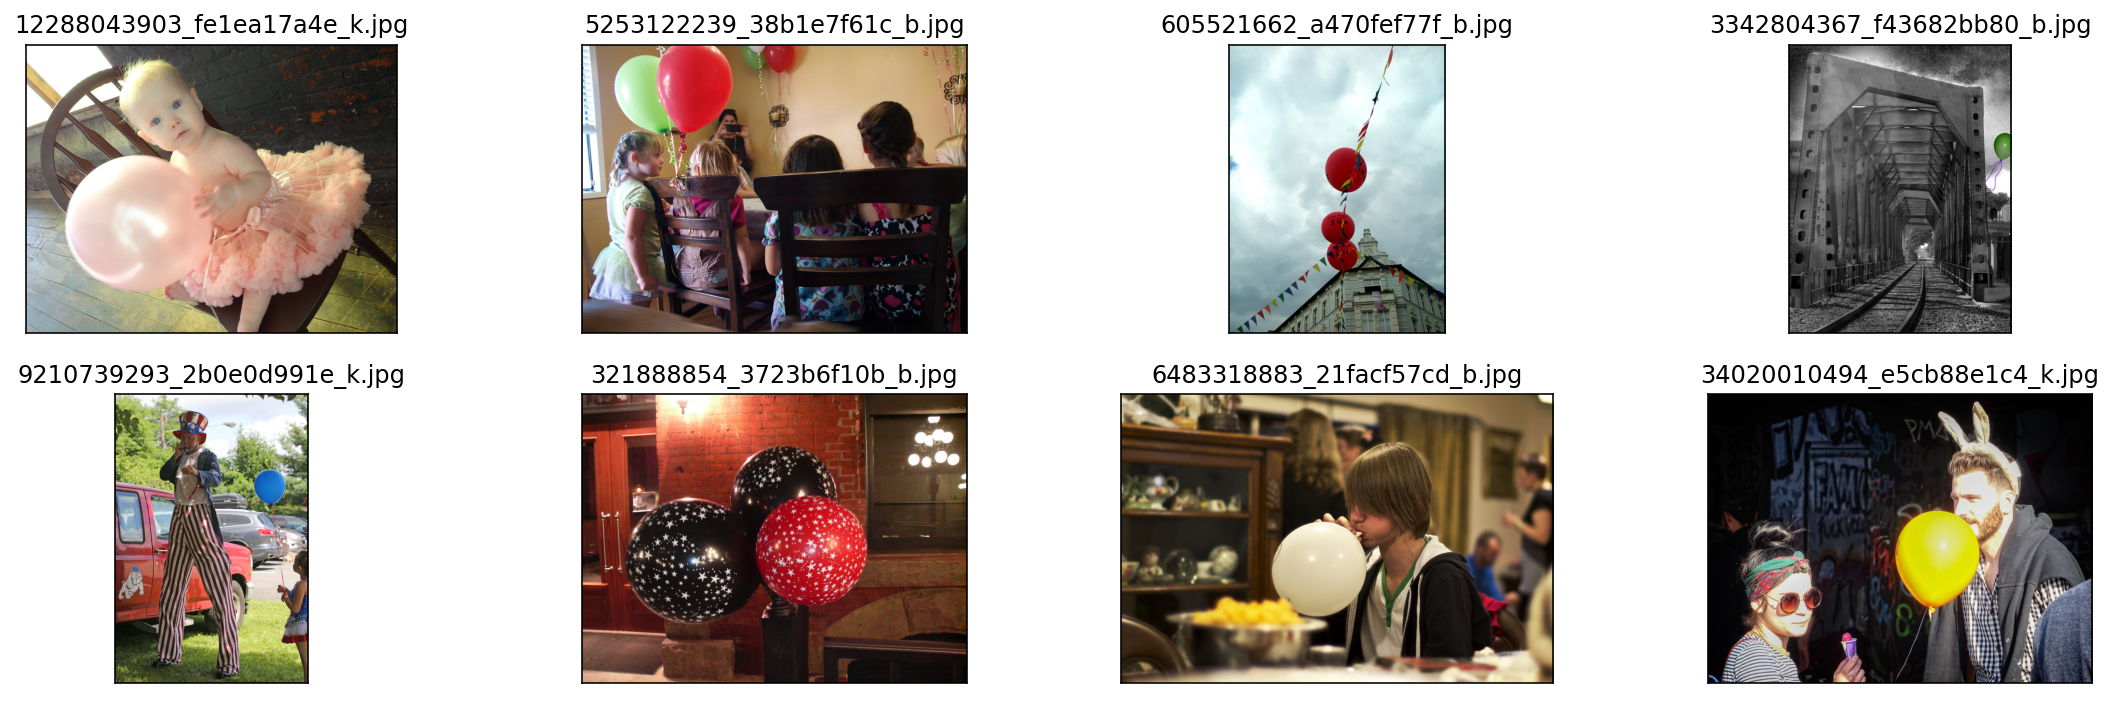

In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

img_path='balloon_dataset/balloon/train/'
image_paths= [filename for filename in os.listdir(img_path)][:8]

for i,filename in enumerate(image_paths):
    name = os.path.splitext(filename)[0]

    image = Image.open(img_path+filename).convert("RGB")
  
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

# Visualize labels

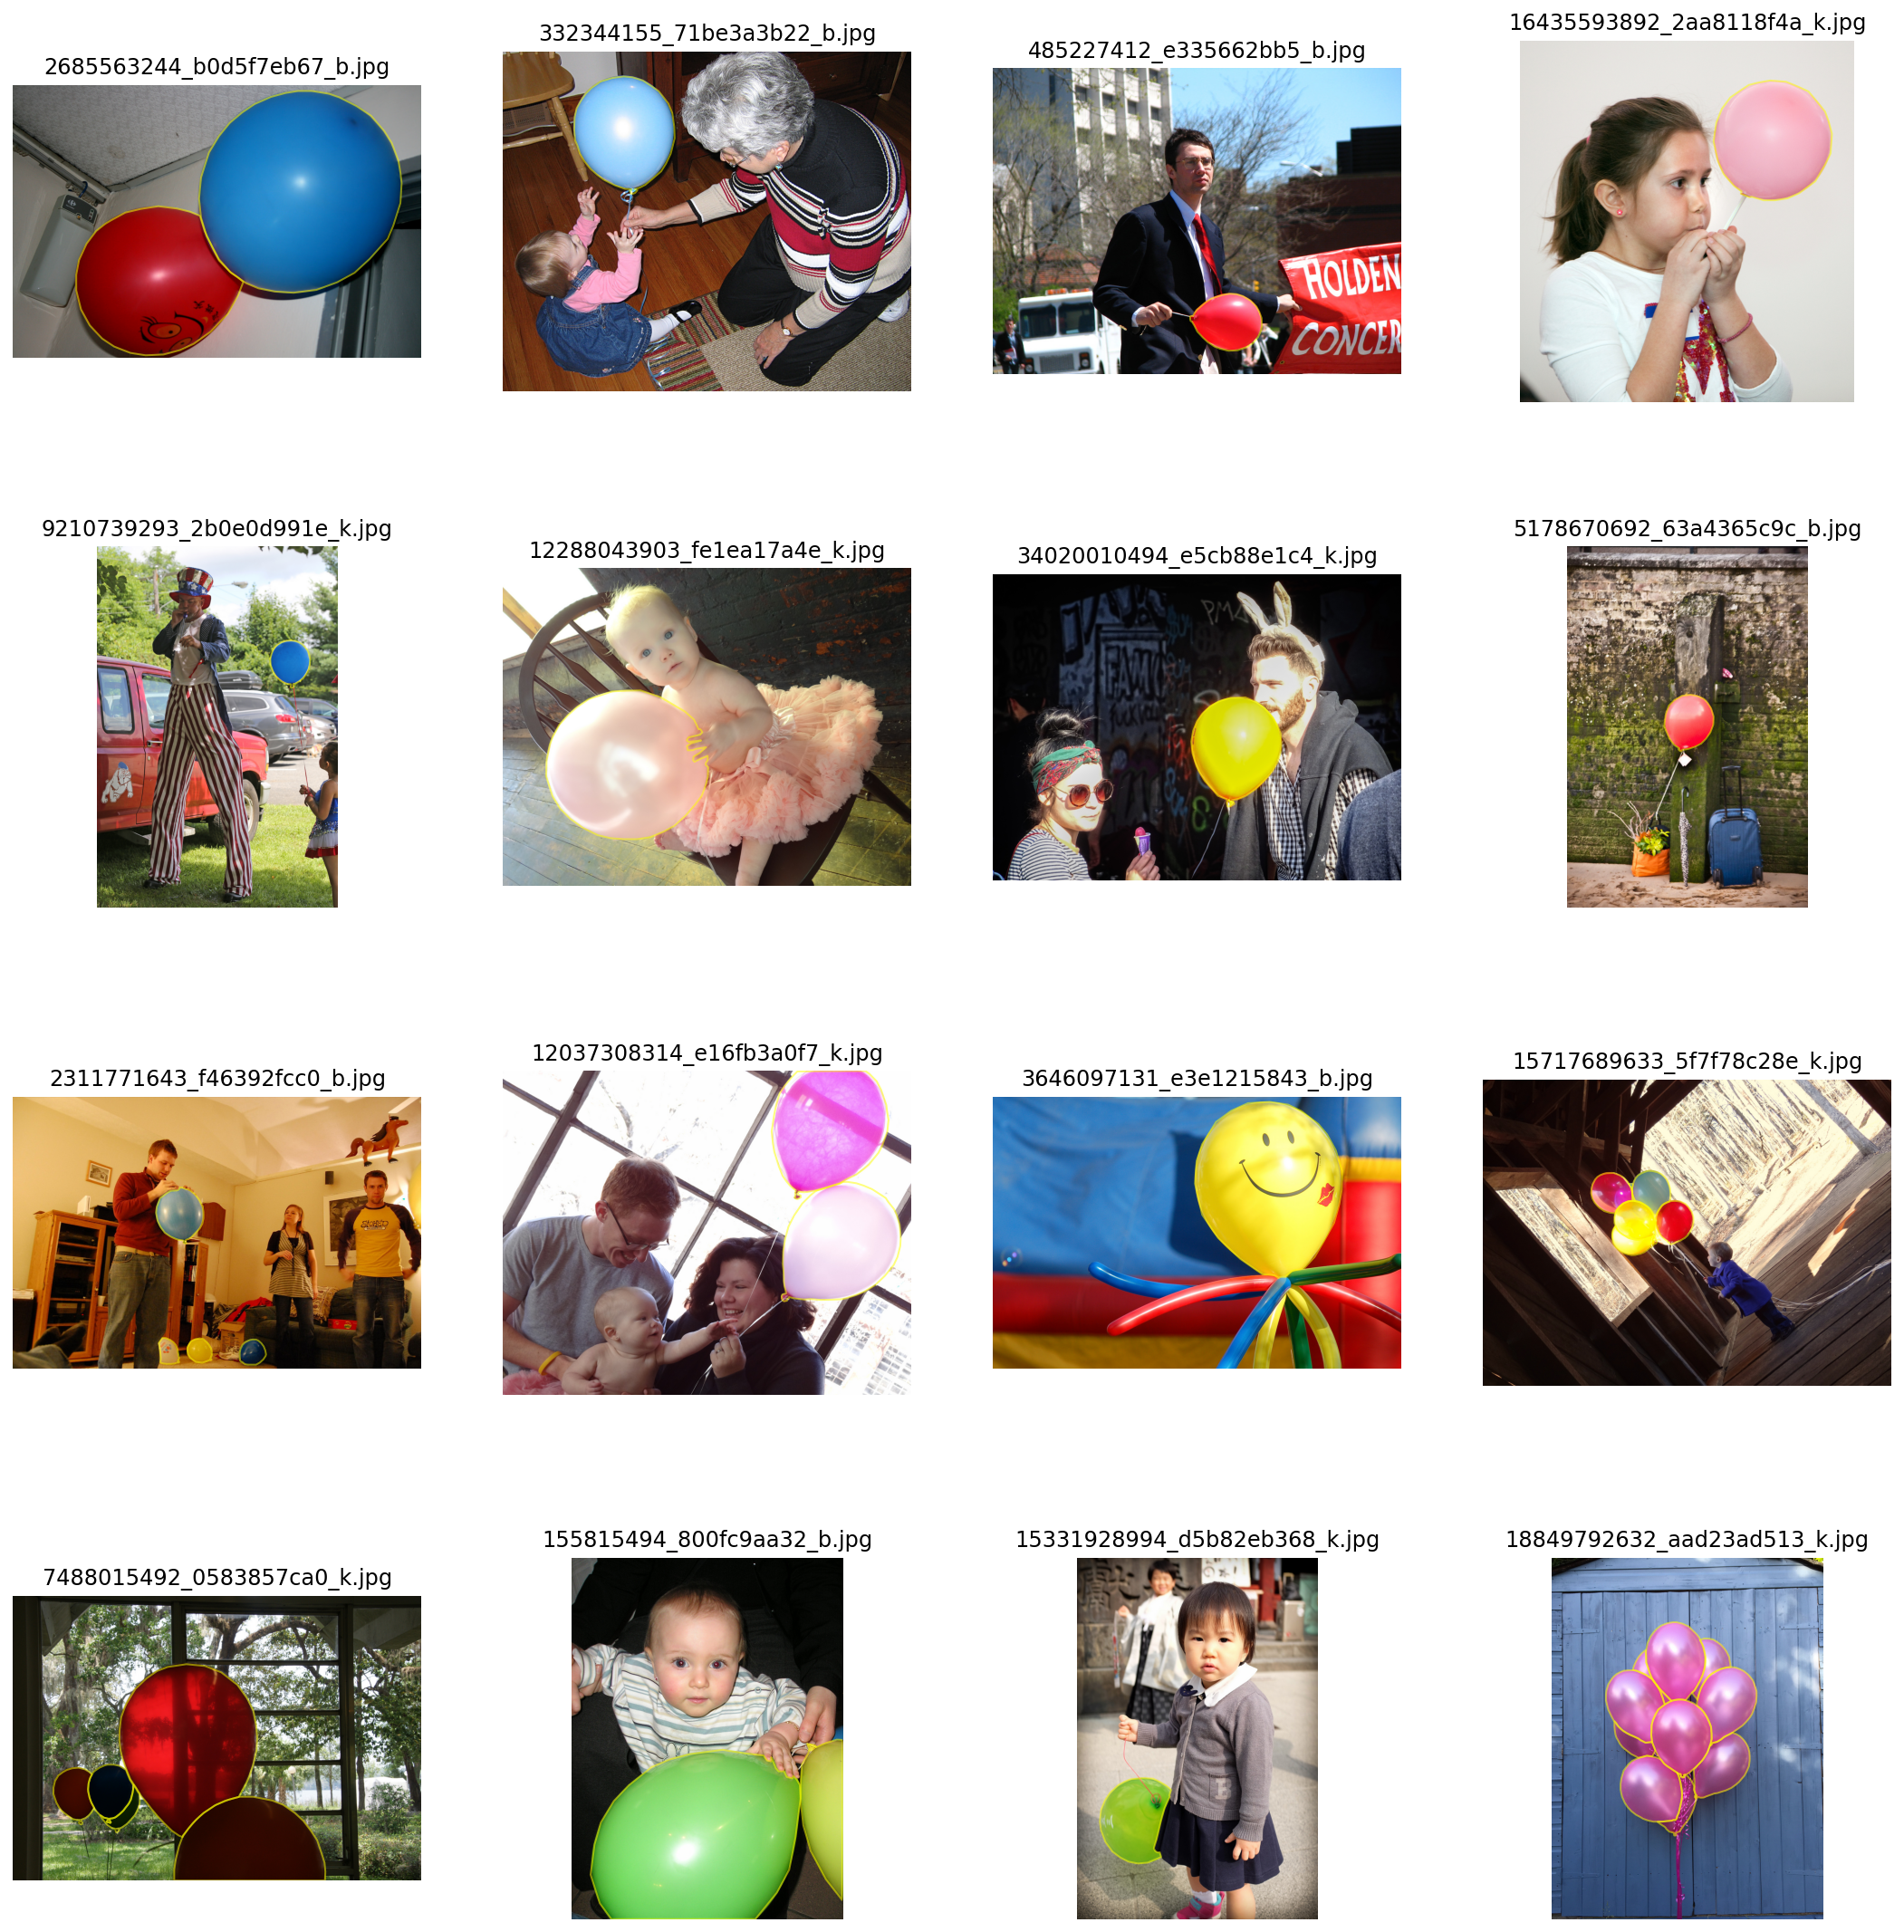

In [7]:
import json
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import random

with open('balloon_dataset/balloon/train/via_region_data.json') as f:
    annotations = json.load(f)

# 获取所有图像的ID
image_ids = list(annotations.keys())

# 随机选择16个图像ID
random_image_ids = random.sample(image_ids, 16)

# 创建一个4x4的子图
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# 遍历每个图像ID
for i, image_id in enumerate(random_image_ids):
    # 获取图像的文件名和大小
    filename = annotations[image_id]['filename']
    size = annotations[image_id]['size']
    
    # 读取图像文件
    image = Image.open(f'balloon_dataset/balloon/train/{filename}')
    
    # 获取多边形注释信息
    regions = annotations[image_id]['regions']
    patches = []
    for region_id, region_info in regions.items():
        # 获取多边形顶点坐标
        x = region_info['shape_attributes']['all_points_x']
        y = region_info['shape_attributes']['all_points_y']
        points = list(zip(x, y))
        
        # 创建多边形对象
        polygon = Polygon(points, True)
        patches.append(polygon)
    
    # 计算子图的行和列索引
    row = i // 4
    col = i % 4
    
    # 在子图中显示图像和注释
    axs[row, col].imshow(image)
    axs[row, col].set_title(filename)
    p = PatchCollection(patches, alpha=0.5, facecolor='none', edgecolor='yellow')
    axs[row, col].add_collection(p)

# 调整子图的间距和轴的可见性
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.4)
for ax in axs.flat:
    ax.axis('off')

# 显示子图
plt.show()

## Write training config file

In [8]:
!pwd 
!ls

/home/featurize/mmdetection
balloon_dataset  docs		  projects	   requirements.txt  tools
CITATION.cff	 LICENSE	  pytest.ini	   resources
configs		 MANIFEST.in	  README.md	   setup.cfg
demo		 mmdet		  README_zh-CN.md  setup.py
docker		 model-index.yml  requirements	   tests


In [13]:
config_text="""
_base_ = '../configs/rtmdet/rtmdet_tiny_8xb32-300e_coco.py'

data_root = 'balloon_dataset/'

# 非常重要
metainfo = {
    # 类别名，注意 classes 需要是一个 tuple，因此即使是单类，
    # 你应该写成 `cat,` 很多初学者经常会在这犯错
    'classes': ('balloon',),
    'palette': [
        (220, 20, 60),
    ]
}
num_classes = 1

# 训练 100 epoch
max_epochs = 100
# 训练单卡 bs= 12
train_batch_size_per_gpu = 12
# 可以根据自己的电脑修改
train_num_workers = 5

# 验证集 batch size 为 1
val_batch_size_per_gpu = 1
val_num_workers = 5

# RTMDet 训练过程分成 2 个 stage，第二个 stage 会切换数据增强 pipeline
num_epochs_stage2 = 5

# batch 改变了，学习率也要跟着改变， 0.004 是 8卡x32 的学习率
base_lr = 12 * 0.004 / (32*8)

# 采用 COCO 预训练权重
load_from = 'https://download.openmmlab.com/mmdetection/v3.0/rtmdet/rtmdet_tiny_8xb32-300e_coco/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth'  # noqa

model = dict(
    # 考虑到数据集太小，且训练时间很短，我们把 backbone 完全固定
    # 用户自己的数据集可能需要解冻 backbone
    # Stages=4 will freeze all stages.
    backbone=dict(frozen_stages=4),
    # 不要忘记修改 num_classes
    bbox_head=dict(dict(num_classes=num_classes)))

# 数据集不同，dataset 输入参数也不一样
train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    pin_memory=False,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        ann_file='balloon/train/balloon_train.json',
        data_prefix=dict(img='balloon/train/')))

val_dataloader = dict(
    batch_size=val_batch_size_per_gpu,
    num_workers=val_num_workers,
    dataset=dict(
        metainfo=metainfo,
        data_root=data_root,
        ann_file='balloon/val/balloon_val.json',
        data_prefix=dict(img='balloon/val/')))

test_dataloader = val_dataloader

# 默认的学习率调度器是 warmup 1000，但是 cat 数据集太小了，需要修改 为 30 iter
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=30),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,  # max_epoch 也改变了
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]
optim_wrapper = dict(optimizer=dict(lr=base_lr))

# 第二 stage 切换 pipeline 的 epoch 时刻也改变了
_base_.custom_hooks[1].switch_epoch = max_epochs - num_epochs_stage2

val_evaluator = dict(ann_file=data_root + 'balloon/val/balloon_val.json')
test_evaluator = val_evaluator

# 一些打印设置修改
default_hooks = dict(
    checkpoint=dict(interval=10, max_keep_ckpts=2, save_best='auto'),  # 同时保存最好性能权重
    logger=dict(type='LoggerHook', interval=5))
train_cfg = dict(max_epochs=max_epochs, val_interval=10)
"""
write_file = open('balloon_dataset/balloon_rtmdet.py','w')
write_file.write(config_text)
write_file.close()

In [14]:
!ls balloon_dataset

balloon  balloon_rtmdet.py  __MACOSX


## JSON to COCO

In [16]:
!ls

balloon_dataset  docs		  projects	   requirements.txt  tools
CITATION.cff	 LICENSE	  pytest.ini	   resources	     work_dirs
configs		 MANIFEST.in	  README.md	   setup.cfg
demo		 mmdet		  README_zh-CN.md  setup.py
docker		 model-index.yml  requirements	   tests


In [18]:
import cv2
import json
import re
from collections import defaultdict

# 读取JSON文件
with open('balloon_dataset/balloon/train/via_region_data.json') as f:
    annotations = json.load(f)

# 初始化COCO格式字典
coco_dict = defaultdict(list)
coco_dict['info'] = {}
coco_dict['licenses'] = []
coco_dict['categories'] = []
coco_dict['images'] = []
coco_dict['annotations'] = []

# 添加info信息
coco_dict['info']['version'] = '1.0'
coco_dict['info']['description'] = 'Balloon Dataset'
coco_dict['info']['year'] = 2023
coco_dict['info']['contributor'] = 'YUJUNYU'
coco_dict['info']['date_created'] = '2023-06-09'

# 添加categories信息
category_id = 1
category = {'id': category_id, 'name': 'balloon', 'supercategory': 'object'}
coco_dict['categories'].append(category)

# 遍历每个图像的注释信息
annotation_id = 1
for image_id, image_info in annotations.items():
    # 从image_id中提取出正确的图像ID
    match = re.search(r'(\d+)_.*', image_id)
    if match:
        image_id = match.group(1)
    else:
        continue
    
    # 获取图像的文件名和大小
    filename = image_info['filename']
    size = image_info['size']
    # 获取图像的height和width
    img = cv2.imread(os.path.join('balloon_dataset/balloon/train/', filename))
    height, width, _ = img.shape
    # print(filename,height,width)
    
    # 添加图像信息
    image = {'id': int(image_id), 'file_name': filename, 'width': width, 'height': height}
    coco_dict['images'].append(image)
    
    # 获取多边形注释信息
    regions = image_info['regions']
    for region_id, region_info in regions.items():
        # 获取多边形顶点坐标
        x = region_info['shape_attributes']['all_points_x']
        y = region_info['shape_attributes']['all_points_y']
        points = list(zip(x, y))
        
        # 计算多边形的边界框
        xmin = min(x)
        xmax = max(x)
        ymin = min(y)
        ymax = max(y)
        width = xmax - xmin
        height = ymax - ymin
        
        # 添加注释信息
        annotation = {'id': annotation_id, 'image_id': int(image_id), 'category_id': category_id, 'segmentation': [points], 'area': width * height, 'bbox': [xmin, ymin, width, height], 'iscrowd': 0}
        coco_dict['annotations'].append(annotation)
        annotation_id += 1

# 保存COCO格式文件
with open('balloon_dataset/balloon/train/balloon_train.json', 'w') as f:
    json.dump(coco_dict, f)

print('success！')

success！


In [20]:
# 读取JSON文件
with open('balloon_dataset/balloon/val/via_region_data.json') as f:
    annotations = json.load(f)

# 初始化COCO格式字典
coco_dict = defaultdict(list)
coco_dict['info'] = {}
coco_dict['licenses'] = []
coco_dict['categories'] = []
coco_dict['images'] = []
coco_dict['annotations'] = []

# 添加info信息
coco_dict['info']['version'] = '1.0'
coco_dict['info']['description'] = 'Balloon Dataset'
coco_dict['info']['year'] = 2023
coco_dict['info']['contributor'] = 'YUJUNYU'
coco_dict['info']['date_created'] = '2023-06-09'

# 添加categories信息
category_id = 1
category = {'id': category_id, 'name': 'balloon', 'supercategory': 'object'}
coco_dict['categories'].append(category)

# 遍历每个图像的注释信息
annotation_id = 1
for image_id, image_info in annotations.items():
    # 从image_id中提取出正确的图像ID
    match = re.search(r'(\d+)_.*', image_id)
    if match:
        image_id = match.group(1)
    else:
        continue
    
    # 获取图像的文件名和大小
    filename = image_info['filename']
    size = image_info['size']
    # 获取图像的height和width
    img = cv2.imread(os.path.join('balloon_dataset/balloon/val/', filename))
    height, width, _ = img.shape
    # print(filename,height,width)
    
    
    # 添加图像信息
    image = {'id': int(image_id), 'file_name': filename, 'width': width, 'height': height}
    coco_dict['images'].append(image)
    
    # 获取多边形注释信息
    regions = image_info['regions']
    for region_id, region_info in regions.items():
        # 获取多边形顶点坐标
        x = region_info['shape_attributes']['all_points_x']
        y = region_info['shape_attributes']['all_points_y']
        points = list(zip(x, y))
        
        # 计算多边形的边界框
        xmin = min(x)
        xmax = max(x)
        ymin = min(y)
        ymax = max(y)
        width = xmax - xmin
        height = ymax - ymin
        
        # 添加注释信息
        annotation = {'id': annotation_id, 'image_id': int(image_id), 'category_id': category_id, 'segmentation': [points], 'area': width * height, 'bbox': [xmin, ymin, width, height], 'iscrowd': 0}
        coco_dict['annotations'].append(annotation)
        annotation_id += 1

# 保存COCO格式文件
with open('balloon_dataset/balloon/val/balloon_val.json', 'w') as f:
    json.dump(coco_dict, f)

print('success！')

success！


## Training

In [21]:
!python tools/train.py balloon_dataset/balloon_rtmdet.py

06/18 11:55:01 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.10 (default, Jun  4 2021, 14:48:32) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 1265498513
    GPU 0: NVIDIA GeForce RTX 3060
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.2, V11.2.152
    GCC: gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,cod

## Test set

In [22]:
!python tools/test.py balloon_dataset/balloon_rtmdet.py work_dirs/balloon_rtmdet/best_coco_bbox_mAP_epoch_70.pth

06/18 12:04:43 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.10 (default, Jun  4 2021, 14:48:32) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 1802362848
    GPU 0: NVIDIA GeForce RTX 3060
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.2, V11.2.152
    GCC: gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,cod

In [23]:
!pwd

/home/featurize/mmdetection


--2023-06-18 12:06:26--  http://digitalpaper.stdaily.com/http_www.kjrb.com/kjrb/images/2020-10/22/04/824719_lix_1603271812153_b.jpg
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 64987 (63K) [image/jpeg]
正在保存至: “balloon_dataset/balloon_test.png”

balloon_dataset/bal 100%[===================>]  63.46K  --.-KB/s    用时 0.06s   

2023-06-18 12:06:27 (1.06 MB/s) - 已保存 “balloon_dataset/balloon_test.png” [64987/64987])

Loads checkpoint by local backend from path: work_dirs/balloon_rtmdet/best_coco_bbox_mAP_epoch_70.pth
06/18 12:06:36 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
06/18 12:06:36 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.

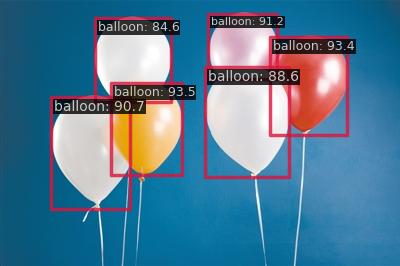

In [24]:
# Single image prediction
# call demo/image_demo.py
!wget http://digitalpaper.stdaily.com/http_www.kjrb.com/kjrb/images/2020-10/22/04/824719_lix_1603271812153_b.jpg -O balloon_dataset/balloon_test.png
!python demo/image_demo.py balloon_dataset/balloon_test.png balloon_dataset/balloon_rtmdet.py --weights work_dirs/balloon_rtmdet/best_coco_bbox_mAP_epoch_70.pth
from PIL import Image
Image.open('outputs/vis/balloon_test.png')

## Visualization of the feature map

In [25]:
%cd ..

/home/featurize


In [26]:
!rm -rf mmyolo
!git clone -b tutorials https://github.com/open-mmlab/mmyolo.git 

正克隆到 'mmyolo'...
remote: Enumerating objects: 4911, done.
remote: Counting objects: 100% (302/302), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 4911 (delta 130), reused 233 (delta 112), pack-reused 4609
接收对象中: 100% (4911/4911), 3.78 MiB | 8.52 MiB/s, 完成.
处理 delta 中: 100% (3014/3014), 完成.


In [29]:
%cd mmyolo
!mim install -e .

/home/featurize/mmyolo
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.10.0/index.html
Obtaining file:///home/featurize/mmyolo
  Running setup.py develop for mmyolo


In [30]:
%cd

/home/featurize


In [31]:
import cv2
img = cv2.imread('mmdetection/balloon_dataset/balloon_test.png')

print(img.shape)
# h,w=img.shape[:2]
# resized_img = cv2.resize(img, (640, 640))
# cv2.imwrite('mmdetection/cat_dataset/cat1_resize.jpg', resized_img)

import os
os.chdir('mmyolo')

(266, 400, 3)


Loads checkpoint by local backend from path: ../mmdetection/work_dirs/balloon_rtmdet/best_coco_bbox_mAP_epoch_70.pth
06/18 12:10:53 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
[                                                  ] 0/1, elapsed: 0s, ETA:/environment/miniconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/environment/miniconda3/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:985: UserWarning: Since the spatial dimensions of overlaid_image: (266, 400) and featmap: torch.Size([80, 80]) are not same, the feature map will be interpolated. This may cause mismatch problems ！
  f'Since the spatial dimensions of '
/environment/miniconda3/lib/python3.7/site-packages/mm

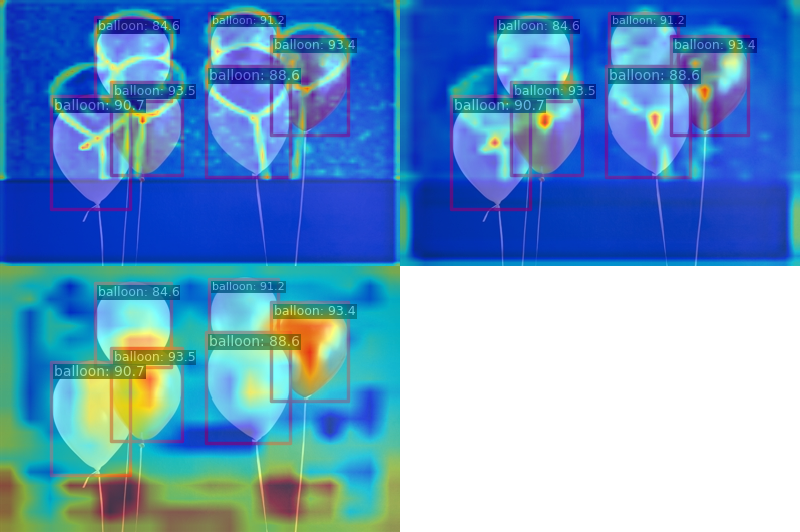

In [32]:
# 1.可视化 backbone 输出的 3 个通道
!python demo/featmap_vis_demo.py \
      ../mmdetection/balloon_dataset/balloon_test.png \
      ../mmdetection/balloon_dataset/balloon_rtmdet.py \
      ../mmdetection/work_dirs/balloon_rtmdet/best_coco_bbox_mAP_epoch_70.pth  \
      --target-layers backbone  \
      --channel-reduction squeeze_mean
from PIL import Image
Image.open('output/balloon_test.png')   

In [34]:
# 2. 可视化 neck 输出的 3 个通道
!python demo/featmap_vis_demo.py \
      ../mmdetection/balloon_dataset/balloon_test.png \
      ../mmdetection/balloon_dataset/balloon_rtmdet.py \
      ../mmdetection/work_dirs/balloon_rtmdet/best_coco_bbox_mAP_epoch_70.pth  \
      --target-layers neck  \
      --channel-reduction squeeze_mean

Loads checkpoint by local backend from path: ../mmdetection/work_dirs/balloon_rtmdet/best_coco_bbox_mAP_epoch_70.pth
06/18 12:11:30 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
[                                                  ] 0/1, elapsed: 0s, ETA:/environment/miniconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/environment/miniconda3/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:985: UserWarning: Since the spatial dimensions of overlaid_image: (266, 400) and featmap: torch.Size([80, 80]) are not same, the feature map will be interpolated. This may cause mismatch problems ！
  f'Since the spatial dimensions of '
/environment/miniconda3/lib/python3.7/site-packages/mm

In [37]:
%ls output

balloon_test.png


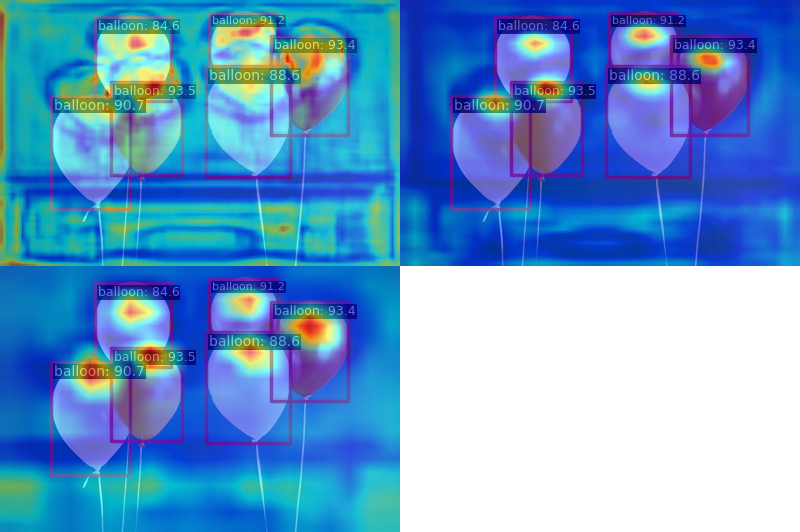

In [38]:
Image.open('output/balloon_test.png')